In [1]:
!pip install geopandas rasterio rioxarray rasterstats folium unidecode plotly matplotlib shapely pyproj fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 49.6 MB/s eta 0:00:00


# MONTAJE DE GOOGLE DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTACIÓN DE LIBRERÍAS

In [3]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import folium
from folium import Choropleth
import unidecode
import numpy as np
import functools
import os
import plotly.express as px
import rioxarray as rxr
from shapely.geometry import mapping
from google.colab import drive
import datetime as dt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib.colors import ListedColormap

FUNCIONES PARA OPTIMIZAR LA LIMPIEZA DE DATOS

In [4]:
def limpiar_indices(*args):
  for i in range (len(df_dirty.columns)):
    df_dirty.columns.values[i] = (df_dirty.columns[i]).lower().replace(' ','_')

def limpiar_strings(*nombres_col):
  for col in nombres_col:
    df_dirty[col] = df_dirty[col].str.lower()

def limpiar_numeros_comas(*nombres_col):
  for col in nombres_col:
    df_dirty[col] = df_dirty[col].str.replace(',', '', regex=False)
    df_dirty[col] = pd.to_numeric(df_dirty[col], errors= 'coerce')

def limpiar_numeros(*nombres_col):
  for col in nombres_col:
    df_dirty[col] = pd.to_numeric(df_dirty[col], errors= 'coerce')

def llenar_vacios(*nombres_col):
  for col in nombres_col:
    df_dirty[col] = df_dirty[col].fillna(df_dirty[col].median())


1 PASO : REALIZAR LA LIMPIEZA DE LOS DATOS

In [53]:
# Cargar datos
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/d2_energia03_05.csv', encoding='latin-1')
df_dirty = df.copy()

# La fila cuyos valores son NaN se elimina
df_dirty.dropna(how='all', inplace=True)
df_dirty = df_dirty.drop(df_dirty.index[0])
df_dirty.reset_index(drop=True, inplace=True)

# Cambiar los nombres de columnas a minúsculas y sin espacios
for i in range(len(df_dirty.columns)):
    df_dirty.columns.values[i] = df_dirty.columns[i].lower().replace(' ', '_')

# Cambiar a valores numéricos
df_dirty['establecimientos'] = pd.to_numeric(df_dirty['establecimientos'], errors='coerce')
df_dirty['capacidad_instalada_(mw)'] = pd.to_numeric(df_dirty['capacidad_instalada_(mw)'], errors='coerce')
df_dirty['generacion_(gwh/a)'] = pd.to_numeric(df_dirty['generacion_(gwh/a)'], errors='coerce')

# Cambiar a minúsculas
df_dirty['entidad_federativa'] = df_dirty['entidad_federativa'].str.lower()
df_dirty['sector'] = df_dirty['sector'].str.lower()
df_dirty['tipo_de_energia_limpia'] = df_dirty['tipo_de_energia_limpia'].str.lower()
df_dirty = df_dirty.rename(columns={'entidad_federativa': 'estado'})

# Generar diccionario para llenar datos faltantes con la mediana
columnas_limpiar = {
    'estado': 'desconocido',
    'sector': 'desconocido',
    'tipo_de_energia_limpia': 'desconocido',
    'establecimientos': df_dirty['establecimientos'].median(),
    'capacidad_instalada_(mw)': df_dirty['capacidad_instalada_(mw)'].median(),
    'generacion_(gwh/a)': df_dirty['generacion_(gwh/a)'].median()
}
df_energialimpia_por_estado = df_dirty.fillna(columnas_limpiar)
df_energialimpia_por_estado.head(5)

,estado,sector,tipo_de_energia_limpia,establecimientos,capacidad_instalada_(mw),generacion_(gwh/a)
0,aguascalientes,privado,biomasa,2.0,3.63,8.52
1,aguascalientes,privado,cogeneracion eficiente,1.0,4.10,28.53
2,aguascalientes,privado,eolica,1.0,129.00,0.00
3,aguascalientes,privado,solar,1.0,0.79,3.16
4,aguascalientes,privado,total,5.0,137.52,40.21


In [6]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/CapacidadInstaladaTecnologia.csv')
df_dirty = df.copy()

#Cambiar los indices a minúsculas y sin espacios
for i in range (len(df_dirty.columns)):
  df_dirty.columns.values[i] = (df_dirty.columns[i]).lower().replace(' ','_')

#Cambiar a valores numéricos
df_dirty['cantidad']=pd.to_numeric(df_dirty['cantidad'], errors='coerce')

#Cambiar a minúsculas
df_dirty['nombre'] = df_dirty['nombre'].str.lower()
df_dirty['nombre'] = df_dirty['nombre'].replace('hidroeléctrica','hidroelectrica')
df_dirty['nombre'] = df_dirty['nombre'].replace('termoeléctrica convencional','termoelectrica_convencional')
df_dirty['nombre'] = df_dirty['nombre'].replace('eoloeléctrica','eoelectrica')
df_dirty['nombre'] = df_dirty['nombre'].replace('solar fotovoltaica','solar_fotovoltaica')
df_dirty['nombre'] = df_dirty['nombre'].replace('carboeléctrica','carboelectrica')
df_dirty['nombre'] = df_dirty['nombre'].replace('turbogás','turbogas')
df_dirty['nombre'] = df_dirty['nombre'].replace('cogeneración eficiente','cogeneracion_eficiente')
df_dirty['nombre'] = df_dirty['nombre'].replace('nucleoeléctrica','nucleoelectrica')
df_dirty['nombre'] = df_dirty['nombre'].replace('geotermoeléctrica','geotermoelectrica')
df_dirty['nombre'] = df_dirty['nombre'].replace('combustión interna','combustion_interna')
df_dirty['nombre'] = df_dirty['nombre'].replace('bioenergía','bioenergia')

#Ordenar de mayor a menor
df_dirty.sort_values(by=['cantidad'],inplace=True, ascending=0)
df_dirty.reset_index(drop=True, inplace=True) #Se resetea el índice

df_energias_mexico = df_dirty                                                   #Energias a nivel nacional México
df_energias_mexico

,nombre,cantidad
0,ciclo combinado,34413
1,hidroelectrica,12613
2,termoelectrica_convencional,11343
3,eoelectrica,6921
4,solar_fotovoltaica,6535
5,carboelectrica,5463
6,turbogas,3815
7,cogeneracion_eficiente,2308
8,nucleoelectrica,1608
9,geotermoelectrica,976


In [7]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/potencial_energetico_solar_eolico_hidrico.csv', encoding='latin-1')
df_dirty = df.copy()

limpiar_indices(df_dirty)
limpiar_strings('estado')
limpiar_numeros_comas('solar')
df_dirty['eolica'] = pd.to_numeric(df_dirty['eolica'], errors='coerce')
df_dirty['eolica'] = df_dirty['eolica'].fillna(df_dirty['eolica'].median())

#Limpiar acentos
df_dirty['estado'] = df_dirty['estado'].replace('michoacán','michoacan')
df_dirty['estado'] = df_dirty['estado'].replace('méxico','mexico')
df_dirty['estado'] = df_dirty['estado'].replace('querétaro','queretaro')
df_dirty['estado'] = df_dirty['estado'].replace('yucatán','yucatan')

df_potencial_solar_eolica_hidro = df_dirty                                      #Potencial energético de energias solar, eolico, hidroelectrico por estado de México
df_potencial_solar_eolica_hidro.head(5)

,estado,solar,eolica,hidroelectrica
0,aguascalientes,1950.8,1.6,si
1,baja california,1965.0,26.3,si
2,baja california sur,1894.0,21.8,si
3,campeche,1708.0,2.2,si
4,cdmx,1810.0,7.0,no


In [8]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/CapacidadInstalada2013-2023 (1).csv', encoding='latin-1')
df_dirty = df.copy()

#Cambiar los indices a minúsculas y sin espacios
for i in range (len(df_dirty.columns)):
  df_dirty.columns.values[i] = (df_dirty.columns[i]).lower().replace(' ','_')

df_dirty= df_dirty.rename(columns = {'ï»¿anio':'anio'}) #Error de acento

df_energias_limpias_por_anio = df_dirty
df_energias_limpias_por_anio.head(5)                                           #Energias limpias en México desde el 2013 al 2023

,anio,carboelectrica,nucleoelectrica,ciclocombinado,terminacombustion,geotermica,hidroelectrica,eolica,fotovoltaica
0,2013,5498,1634,23720,18766,940,11621,1959,33
1,2014,5498,1634,23900,19129,940,12414,2655,100
2,2015,5498,1634,23930,19872,992,12417,3233,149
3,2016,5498,1634,26037,20613,992,12635,4009,189
4,2017,5498,1634,26944,21054,992,12641,4474,275


In [9]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/PIB_por_estado.csv', encoding='latin-1')
df_dirty = df.copy()

#Cambiar a minusculas y acentos
df_dirty['estado'] = df_dirty['estado'].str.lower()
df_dirty['estado'] = df_dirty['estado'].str.strip()

df_dirty['estado'] = df_dirty['estado'].replace('yucatán','yucatan')
df_dirty['estado'] = df_dirty['estado'].replace('méxico','mexico')
df_dirty['estado'] = df_dirty['estado'].replace('yucatán','yucatan')
df_dirty['estado'] = df_dirty['estado'].replace('nuevo león','nuevo leon')
df_dirty['estado'] = df_dirty['estado'].replace('coahuila de zaragoza','coahuila')
df_dirty['estado'] = df_dirty['estado'].replace('michoacán de ocampo','michoacan')
df_dirty['estado'] = df_dirty['estado'].replace('veracruz de ignacio de la llave','veracruz')

#Cambiar valores a numéricos
for anio in ['2019', '2020', '2021']:
    df_dirty[anio] = df_dirty[anio].str.replace(',', '', regex=False)
    df_dirty[anio] = pd.to_numeric(df_dirty[anio], errors = 'coerce' )

df_pib_por_estado = df_dirty
df_pib_por_estado.head(5)                                                       #PIB en cada estado de México de 2019 a 2021

,estado,2019,2020,2021
0,aguascalientes,305134,306745,318347
1,baja california,806895,804612,923218
2,baja california sur,217480,171019,212813
3,campeche,624206,457689,483398
4,coahuila,848957,793707,901801


In [10]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/consumo_energetico.csv', encoding = 'latin-1')
#Se realiza una copia del consumoenergetico
df_dirty = df.copy()

df_dirty = df_dirty.dropna(axis=1, how='any')
df_dirty = df_dirty.rename(columns={'ï»¿estado':'estado'})

limpiar_numeros('agricola','publico','comercial','mediana_industria','grande_industria','residencial','total')
llenar_vacios('agricola','publico','comercial','mediana_industria','grande_industria','residencial')
limpiar_strings('estado')
df_dirty['estado'] = df_dirty['estado'].replace('mã©xico','mexico')
df_dirty['estado'] = df_dirty['estado'].replace('michoacã¡n','michoacan')
df_dirty['estado'] = df_dirty['estado'].replace('querã©taro','queretaro')
df_dirty['estado'] = df_dirty['estado'].replace('yucatã¡n','yucatan')

#Desglose del consumo energético en cada estado de México
df_consumo_energetico_estado = df_dirty                                         #Consumo energético en cada estado de México
df_consumo_energetico_estado.head(5)

,estado,agricola,publico,comercial,mediana_industria,grande_industria,residencial,total
0,aguascalientes,326,55,159,1280,515,524,2860
1,baja california,334,108,606,5173,1694,4465,12382
2,baja california sur,208,32,216,1224,82,1070,2835
3,campeche,34,68,113,370,6,775,1370
4,cdmx,1,70,1567,6654,145,3441,11887


In [11]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/nuevos_proyectos.csv', encoding='latin-1')
df_dirty = df.copy()

#Borramos filas y columnas innecesarias
df_dirty.drop(0, inplace=True)
df_dirty.drop(1, inplace=True)
df_dirty.rename(columns={'Unnamed: 0': 'estado', 'nuevos_proyectos':'potencia'}, inplace=True)
df_dirty.reset_index(drop=True, inplace=True)

#Cambiar a minusculas y acento en yucatán
df_dirty['estado'] = df_dirty['estado'].str.lower()
df_dirty['estado'] = df_dirty['estado'].replace('yucat\xa0n','yucatan')
df_dirty['potencia'] = pd.to_numeric(df_dirty['potencia'], errors = 'coerce' )

df_nuevos_proyectos_solar = df_dirty                                            #Nuevos proyectos por estado en energía solar
df_nuevos_proyectos_solar.head(5)

,estado,potencia
0,aguascalientes,545.6
1,baja california,41.0
2,chihuahua,329.0
3,coahuila,580.0
4,guanajuato,307.0


In [12]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/potencial_energetico.csv', encoding='latin-1')
df_dirty = df.copy()

df_dirty.dropna(axis=0,how = 'any', inplace=True)
df_dirty.reset_index(drop=True, inplace=True) #Se resetea el índice

#Limpiar índices
limpiar_indices(df_dirty)

#Limpiar el potencial
limpiar_numeros('potencial')

df_potencial_geotermico = df_dirty                                              #Mayor potencial geotérmico en México
df_potencial_geotermico.head(5)

,estado,potencial,zona
0,Chiapas,46,Volcan Chichonal
1,Chiapas,60,Volcan Tacan
2,Chihuahua,1,Maguarichic
3,Chihuahua,27,San Antonio El Bravo
4,Durango,4,Santiago Papasquiaro


In [13]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/ITER2020_subset_oportunidades.csv')
df_limpio = df.head()

df_limpio.columns = (
    df_limpio.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)

df_limpio = df_limpio.dropna(how='all')
df_limpio = df_limpio.fillna(0)

suma_estado = df_limpio.groupby(['entidad', 'nom_ent'], as_index=False).sum(numeric_only=True)
suma_municipio = df_limpio.groupby(['entidad', 'nom_ent', 'mun', 'nom_mun'], as_index=False).sum(numeric_only=True)

suma_estado

,entidad,nom_ent,mun,loc,vivtot
0,0,Total nacional,0,19997,44066268
1,1,Aguascalientes,0,9998,465340


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/yearly_full_release_long_format.csv', encoding='latin-1')
df_mundial = df                                                                 #Datos energéticos mundiales
display(df_mundial)

,Area,ISO 3 code,Year,Area type,Continent,Ember region,EU,OECD,G20,G7,ASEAN,Category,Subcategory,Variable,Unit,Value,YoY absolute change,YoY % change
0,Afghanistan,AFG,2000,Country or economy,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Clean,GW,0.19,NaN,NaN
1,Afghanistan,AFG,2000,Country or economy,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Fossil,GW,0.03,NaN,NaN
2,Afghanistan,AFG,2000,Country or economy,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Gas and Other Fossil,GW,0.03,NaN,NaN
3,Afghanistan,AFG,2000,Country or economy,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,"Hydro, Bioenergy and Other Renewables",GW,0.19,NaN,NaN
4,Afghanistan,AFG,2000,Country or economy,Asia,Asia,0.0,0.0,0.0,0.0,0.0,Capacity,Aggregate fuel,Renewables,GW,0.19,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357009,Zimbabwe,ZWE,2023,Country or economy,Africa,Africa,0.0,0.0,0.0,0.0,0.0,Power sector emissions,Fuel,Other Fossil,mtCO2,0.00,0.00,NaN
357010,Zimbabwe,ZWE,2023,Country or economy,Africa,Africa,0.0,0.0,0.0,0.0,0.0,Power sector emissions,Fuel,Other Renewables,mtCO2,0.00,0.00,NaN
357011,Zimbabwe,ZWE,2023,Country or economy,Africa,Africa,0.0,0.0,0.0,0.0,0.0,Power sector emissions,Fuel,Solar,mtCO2,0.00,0.00,NaN
357012,Zimbabwe,ZWE,2023,Country or economy,Africa,Africa,0.0,0.0,0.0,0.0,0.0,Power sector emissions,Fuel,Wind,mtCO2,0.00,0.00,NaN


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/Estacion_AGUASCALIENTES__90_dias.csv', encoding='latin-1', header=1)
df = df.dropna(how='all')
df = df.dropna(axis=1, how='all')
df = df.drop(columns =df.columns[1])
columnas = list(df.iloc[0])
df = df.set_axis(columnas, axis=1)
df = df.drop(7)
df.reset_index(drop=True, inplace=True)
df['Fecha Local'] = pd.to_datetime(df['Fecha Local'])
df['Fecha Local'] = df['Fecha Local'].dt.hour
df_ags = df
df_ags

,Fecha Local,Temperatura del Aire (°C),Precipitación (mm),Humedad relativa (%),Presión Atmosférica (hpa),Radiación Solar (W/m²),Dirección del Viento (grados),Rapidez de viento (km/h),Dirección de ráfaga (grados),Rapidez de ráfaga (km/h)
0,9,14.6,0,35,822.3,466,327,5.4,136,15.12
1,9,14,0,36,822.3,428,324,4.68,147,10.44
2,8,13.9,0,38,822.2,384,345,3.24,158,9.72
3,8,13.1,0,41,822.2,349,348,2.88,170,7.56
4,8,12.5,0,44,822.1,306,31,1.8,236,6.48
...,...,...,...,...,...,...,...,...,...,...
11917,10,23.8,0,52,821.2,536,66,8.64,166,23.76
11918,10,23.5,0,51,821.2,811,74,7.56,251,17.64
11919,10,22.4,0,53,821.2,404,84,6.48,174,14.04
11920,10,22.5,0,52,821.2,307,74,8.28,242,19.08


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/proyecto_db/Estacion_PUERTO ANGEL__90_dias.csv', encoding='latin-1')
df = df.dropna(axis=1, how='all')
df = df.dropna(how='any')
columnas = list(df.iloc[0])
df = df.set_axis(columnas, axis=1)
df = df.drop(8)
df.reset_index(drop=True, inplace=True)
df_oaxaca = df
df_oaxaca

,Fecha Local,Fecha UTC,Temperatura del Aire (°C),Precipitación (mm),Humedad relativa (%),Presión Atmosférica (hpa),Radiación Solar (W/m²),Dirección del Viento (grados),Rapidez de viento (km/h),Dirección de ráfaga (grados),Rapidez de ráfaga (km/h)
0,2025-11-05 21:30:06,2025-11-06 03:30:06,25.3,0,96,1009.3,-1,357,9.36,13,12.24
1,2025-11-05 21:20:06,2025-11-06 03:20:06,25.3,0,95,1009.2,-1,357,9,21,11.52
2,2025-11-05 21:10:06,2025-11-06 03:10:06,25.3,0,96,1009.1,-1,354,8.28,10,10.44
3,2025-11-05 21:00:06,2025-11-06 03:00:06,25.3,0,96,1009.1,-1,359,9.36,16,12.6
4,2025-11-05 20:50:06,2025-11-06 02:50:06,25.3,0,95,1009,-1,351,10.08,14,13.68
...,...,...,...,...,...,...,...,...,...,...,...
6700,2025-08-08 06:40:00,2025-08-08 12:40:00,25.8,0,84,1008.2,96,318,11.88,337,16.2
6701,2025-08-08 06:30:00,2025-08-08 12:30:00,25.6,0,85,1008.1,65,317,11.88,342,16.92
6702,2025-08-08 06:20:00,2025-08-08 12:20:00,25.3,0,87,1008.2,22,324,12.24,336,15.12
6703,2025-08-08 06:10:00,2025-08-08 12:10:00,25.3,0,88,1008.2,13,322,12.6,335,17.64


In [ ]:
def imputar_valores(df, columna, metodo='media', valor_manual=None):
    """
    Imputa valores faltantes en una columna del DataFrame.
    metodo: 'media', 'mediana', 'moda' o 'manual'
    valor_manual: número o texto para imputar manualmente.
    """
    if columna not in df.columns:
        print(f" La columna '{columna}' no existe en este DataFrame.")
        return df
     #Selección del método de imputación
    if metodo == 'media':
        valor = df[columna].mean()
    elif metodo == 'mediana':
        valor = df[columna].median()
    elif metodo == 'moda':
        valor = df[columna].mode()[0]
    elif metodo == 'manual' and valor_manual is not None:
        valor = valor_manual
    else:
        print(f"Método '{metodo}' no reconocido o valor manual no definido.")
        return df

    # Aplicar imputación
    df[columna].fillna(valor, inplace=True)
    print(f"Imputación en '{columna}' usando {metodo}: {valor}")
    return df

## Procedimientos

In [ ]:
#Energía del sector solar unicamente
idx = df_energialimpia_por_estado['tipo_de_energia_limpia'].values == 'solar'
df_solar_por_estado = pd.DataFrame(df_energialimpia_por_estado.values[idx], columns=df_energialimpia_por_estado.columns, index=None)

#Unificar los dataframes
df_solar = pd.merge(df_potencial_solar_eolica_hidro,df_nuevos_proyectos_solar, on='estado', how='left')
df_solar = pd.merge(df_solar,df_solar_por_estado, on = 'estado',how = 'left')
df_solar = df_solar.drop(columns = ['eolica', 'hidroelectrica','establecimientos','tipo_de_energia_limpia'])
df_solar = df_solar.rename(columns = {'potencia':'potencia_nuevos_proyectos_(kWh/kWp)'})
df_solar = df_solar.rename(columns = {'solar':'potencial_energetico'})

#Conversión a numericos
df_solar['capacidad_instalada_(mw)'] = pd.to_numeric(df_solar['capacidad_instalada_(mw)'], errors='coerce')
df_solar['generacion_(gwh/a)'] = pd.to_numeric(df_solar['generacion_(gwh/a)'], errors='coerce')

#Llenar los NaN
df_solar['potencia_nuevos_proyectos_(kWh/kWp)'] = df_solar['potencia_nuevos_proyectos_(kWh/kWp)'].fillna('Sin_proyectos')
df_solar['capacidad_instalada_(mw)'] = df_solar['capacidad_instalada_(mw)'].fillna(df_solar['capacidad_instalada_(mw)'].median())
df_solar['generacion_(gwh/a)'] = df_solar['generacion_(gwh/a)'].fillna(df_solar['generacion_(gwh/a)'].median())
df_solar['sector'] = df_solar['sector'].fillna('general')


#Energía del sector eolico unicamente
idx = df_energialimpia_por_estado['tipo_de_energia_limpia'].values == 'eolica'
df_eolico_por_estado = pd.DataFrame(df_energialimpia_por_estado.values[idx], columns=df_energialimpia_por_estado.columns, index=None)

#Unificar los dataframes
df_eolica = pd.merge(df_potencial_solar_eolica_hidro,df_eolico_por_estado, on='estado', how='left')
df_eolica = df_eolica.drop(columns = ['solar', 'hidroelectrica','establecimientos','tipo_de_energia_limpia'])
df_eolica = df_eolica.rename (columns={'eolica':'potencial_(km/h)'})

#Conversión a numericos
df_eolica['capacidad_instalada_(mw)'] = pd.to_numeric(df_eolica['capacidad_instalada_(mw)'], errors='coerce')
df_eolica['generacion_(gwh/a)'] = pd.to_numeric(df_eolica['generacion_(gwh/a)'], errors='coerce')

#Llenar los NaN
df_eolica['capacidad_instalada_(mw)'] = df_eolica['capacidad_instalada_(mw)'].fillna(df_eolica['capacidad_instalada_(mw)'].median())
df_eolica['generacion_(gwh/a)'] = df_eolica['generacion_(gwh/a)'].fillna(df_eolica['generacion_(gwh/a)'].median())
df_eolica['sector'] = df_eolica['sector'].fillna('general')


#Energía del sector eolico unicamente
idx = df_energialimpia_por_estado['tipo_de_energia_limpia'].values == 'geotermica'
df_geotermica_por_estado = pd.DataFrame(df_energialimpia_por_estado.values[idx], columns=df_energialimpia_por_estado.columns, index=None)

#Unificar los dataframes
df_geotermica = pd.merge(df_potencial_geotermico,df_geotermica_por_estado, on='estado', how='left')
df_geotermica = df_geotermica.drop(columns = ['establecimientos','tipo_de_energia_limpia'])
df_geotermica = df_geotermica.rename (columns={'zona':'zona_del_potencial'})
df_geotermica = df_geotermica.rename (columns={'potencial':'potencial_(mw)'})

#Llenar NaN
df_geotermica['capacidad_instalada_(mw)'] = df_geotermica['capacidad_instalada_(mw)'].fillna('sin_central')
df_geotermica['generacion_(gwh/a)'] = df_geotermica['generacion_(gwh/a)'].fillna('sin_central')
df_geotermica['sector'] = df_geotermica['sector'].fillna('general')


#Energía del sector hidroeléctrico unicamente
idx = df_energialimpia_por_estado['tipo_de_energia_limpia'].values == 'hidraulica'
df_hidraulica_por_estado = pd.DataFrame(df_energialimpia_por_estado[idx],columns = df_energialimpia_por_estado.columns, index=None)

#Unificar Dataframes
df_hidraulica = pd.merge(df_hidraulica_por_estado,df_potencial_solar_eolica_hidro, on = 'estado', how = 'left')
df_hidraulica = df_hidraulica.drop(columns = {'tipo_de_energia_limpia','solar','eolica','establecimientos','hidroelectrica'})

In [ ]:
pib_promedio = df_pib_por_estado['2021'].mean()

#Declarar las listas
list_estado = list()
list_valor = list()

#Extraer datos mayores al promedio
for indice, fila in df_pib_por_estado.iterrows():
  if fila['2021'] > pib_promedio:
    list_estado.append(fila['estado'])
    list_valor.append(fila['2021'])

#Crear el dataframe
df_mayor_pib = pd.Series(list_valor, index=list_estado)
df_mayor_pib = df_mayor_pib.sort_values(ascending = False)
df_mayor_pib.name = 'pib_2021'
df_mayor_pib = df_mayor_pib.apply(lambda x: f'{x:,.0f}')

## **Resultados**

Potencial económico de cada estado

In [ ]:
print(f"\nPIB promedio en México: {pib_promedio:,.0f}")
print("\nEstados con PIB superior al promedio nacional:")
display(df_mayor_pib.head(10))                                                           #Estados con PIB > al promedio


PIB promedio en México: 757,045

Estados con PIB superior al promedio nacional:


,pib_2021
ciudad de méxico,"3,701,686"
mexico,"2,212,972"
nuevo leon,"2,016,768"
jalisco,"1,759,742"
veracruz,"1,075,630"
guanajuato,"1,029,274"
baja california,"923,218"
coahuila,"901,801"
sonora,"891,434"
chihuahua,"878,625"


Desglose de la energía solar, eólica, geotérmica e hidraulica en cada estado

¿Qué estados tienen la mayor capacidad instalada para cada tipo de energía limpia?

In [ ]:

print("Estados con mayores potenciales energéticos en México")
print('*'*55)
opcion = input("""¿Qué energía renovable desea ver? Seleccione la letra correspondiente
      a. Solar
      b. Eólica
      c. Geotermica
      d. Hidroeléctrico
      """)

match opcion.lower():
  case 'a':
    df_solar = df_solar.sort_values('potencial_energetico', ascending=False)
    display(df_solar)
  case 'b':
    df_eolica = df_eolica.sort_values('potencial_(km/h)', ascending=False)
    display(df_eolica)
  case 'c':
    df_geotermica = df_geotermica.sort_values('potencial_(mw)', ascending=False)
    display(df_geotermica)
  case 'd':
    df_hidraulica = df_hidraulica.sort_values('capacidad_instalada_(mw)', ascending = False)
    display(df_hidraulica)
  case _: print("Opción no válida")

Estados con mayores potenciales energéticos en México
*******************************************************
¿Qué energía renovable desea ver? Seleccione la letra correspondiente
      a. Solar
      b. Eólica
      c. Geotermica
      d. Hidroeléctrico
      a


,estado,potencial_energetico,potencia_nuevos_proyectos_(kWh/kWp),sector,capacidad_instalada_(mw),generacion_(gwh/a)
8,chihuahua,1983.0,329.0,privado,20.000,0.00
1,baja california,1965.0,41.0,cfe,574.850,54.22
2,baja california,1965.0,41.0,privado,1.040,1.64
0,aguascalientes,1950.8,545.6,privado,0.790,3.16
33,zacatecas,1941.0,Sin_proyectos,general,10.925,2.40
11,durango,1939.0,Sin_proyectos,privado,77.260,83.43
22,puebla,1918.0,Sin_proyectos,general,10.925,2.40
4,baja california sur,1894.0,Sin_proyectos,privado,30.000,18.37
3,baja california sur,1894.0,Sin_proyectos,cfe,0.970,1.16
30,tlaxcala,1893.0,Sin_proyectos,general,10.925,2.40


Comparativa de México con los mayores exponentes energéticos del mundo

In [ ]:
#  Agrupar, sumar y filtrar los datos
df_agrupado = df_mundial.groupby('Area', as_index=False)['Value'].sum()
df_agrupado = df_agrupado.sort_values(by='Value', ascending=False)

# Eliminar regiones globales o agrupadas para quedarte con países individuales
df_agrupado = df_agrupado[~df_agrupado['Area'].isin([
    'World', 'G20', 'Asia', 'OECD', 'G7', 'Europe',
    'North America', 'EU', 'Latin America and Caribbean',
    'Middle East', 'ASEAN', 'Africa', 'Oceania', 'South Africa'
])]

#  Mostrar los 14 países principales por valor
df_agrupado.head(14)

,Area,Value
41,China,947190.89
215,United States of America,736725.62
96,India,235056.99
104,Japan,214087.76
170,Russian Federation (the),201931.36
79,Germany,125012.45
36,Canada,119777.07
28,Brazil,109949.58
190,South Korea,96490.32
179,Saudi Arabia,84903.74


# **Análisis de datos**

Comparación de la capacidad y la generación de electricidad a nivel mundial

In [ ]:
#Eliminando columnas innesesarias para la gráfica
df_paises_comparativa = df_mundial.drop(columns = ['YoY % change', 'YoY absolute change', 'ASEAN'] )
df_paises_comparativa = df_paises_comparativa.drop(columns = df_paises_comparativa.columns[3:10])

# Filtrando los datos
df_paises_comparativa = df_paises_comparativa[df_paises_comparativa['Category'].isin(['Capacity', 'Electricity generation'])]
df_paises_comparativa = df_paises_comparativa[df_paises_comparativa['Year'] == 2023]
df_paises_comparativa = df_paises_comparativa[df_paises_comparativa['Subcategory'] == 'Aggregate fuel']
df_paises_comparativa = df_paises_comparativa[df_paises_comparativa['Variable'].isin(['Hydro, Bioenergy and Other Renewables','Renewables','Wind and Solar','Bioenergy','Nuclear'])]
df_paises_comparativa = df_paises_comparativa[df_paises_comparativa['Unit'].isin(['GW', 'TWh'])]

In [ ]:
def scatter_mundial(df_paises_comparativa, paises):
  df_paises_comparativa = df_paises_comparativa[df_paises_comparativa['Area'].isin(paises)] #Selecciona los datos de los paises elegidos
  # Sumatoria del valor total de la energía generada
  totales = df_paises_comparativa.groupby(['Area', 'Category'], as_index=False)['Value'].sum()
  totales.rename(columns = {'Value': 'Total'}, inplace=True)
  df_paises_comparativa = df_paises_comparativa.merge(totales, on=['Area', 'Category'], how='left')

  # Pivote de capacidad y electricidad generada por pais
  df_pivot = df_paises_comparativa.pivot_table(index='Area', columns='Category', values='Total').reset_index()
  df_pivot.replace('Russian Federation (the)', 'Russia')
  return df_pivot

def formato_dfmundial ():
  plt.figure(figsize=(12,8))
  plt.scatter(df_pivot['Capacity'], df_pivot['Electricity generation'])
  plt.xlabel('Capacidad (GW)')
  plt.ylabel('Generación de electricidad (TWh)')
  plt.title('Capacidad vs generación de electricidad de cada pais (2023)')
  plt.grid(True)

def etiquetas(df_pivot, ax):
  for i, row in df_pivot.iterrows():
    if row.iloc[0] == 'United Kingdom':
      ax.text(
        row['Capacity'],
        row['Electricity generation'] - 25,
        row['Area'],
        fontsize=10,
        ha='center',
        va='bottom'
      )
    else:
      ax.text(
        row['Capacity'],
        row['Electricity generation'],
        row['Area'],
        fontsize=10,
        ha='center',
        va='bottom'
      )


******************************************************************************************************************************************************
Tipos de energías consideradas: 'Hydro, Bioenergy and Other Renewables', 'Renewables', 'Wind and Solar', 'Bioenergy', 'Nuclear'
******************************************************************************************************************************************************


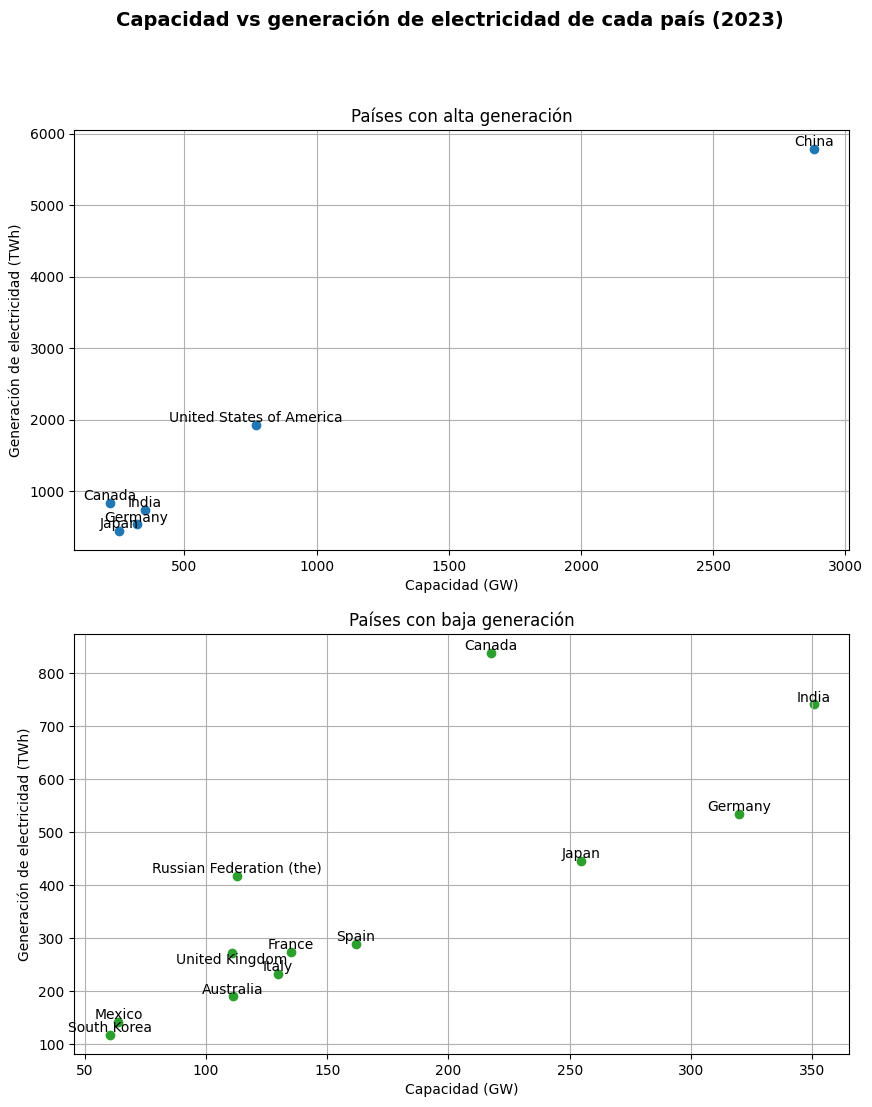

In [ ]:
print("*" * 150)
print("Tipos de energías consideradas: 'Hydro, Bioenergy and Other Renewables', 'Renewables', 'Wind and Solar', 'Bioenergy', 'Nuclear'")
print("*" * 150)


fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 12))
fig.suptitle('Capacidad vs generación de electricidad de cada país (2023)', fontsize=14, fontweight='bold')

#--------------- Primer subplot -----------------
paises_alta = ['Germany', 'Japan', 'India', 'Canada', 'China', 'United States of America']
df_pivot = scatter_mundial(df_paises_comparativa, paises_alta)

ax1.scatter(df_pivot['Capacity'], df_pivot['Electricity generation'], color='tab:blue')
etiquetas(df_pivot, ax1)
ax1.set_xlabel('Capacidad (GW)')
ax1.set_ylabel('Generación de electricidad (TWh)')
ax1.set_title('Países con alta generación')
ax1.grid(True)

#--------------- Segundo subplot ----------------
paises_baja = [
    'Germany', 'Japan', 'India', 'United Kingdom', 'France', 'Italy',
    'Russian Federation (the)', 'Canada', 'Spain', 'Mexico', 'South Korea', 'Australia'
]

df_pivot = scatter_mundial(df_paises_comparativa, paises_baja)

ax2.scatter(df_pivot['Capacity'], df_pivot['Electricity generation'], color='tab:green')
etiquetas(df_pivot, ax2)
ax2.set_xlabel('Capacidad (GW)')
ax2.set_ylabel('Generación de electricidad (TWh)')
ax2.set_title('Países con baja generación')
ax2.grid(True)

plt.show()


In [ ]:
print("-----Detector de valores atípicos en Capacity----------------")
df_paises_capacidad = df_paises_comparativa[df_paises_comparativa['Category'] == 'Capacity']
df_paises_capacidad = df_paises_capacidad.groupby('Area')['Value'].sum().reset_index()
q1 = df_paises_capacidad['Value'].quantile(0.25)
q3 = df_paises_capacidad['Value'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5*iqr
limite_superior = q3 + 1.5*iqr

valores_inferior = df_paises_capacidad[df_paises_capacidad['Value']<limite_inferior]
valores_superior = df_paises_capacidad[df_paises_capacidad['Value']>limite_superior]

if not valores_inferior.empty or not valores_superior.empty:
  df_paises_capacidad.loc[df_paises_capacidad['Value']<limite_inferior, 'Value'] = limite_inferior
  df_paises_capacidad.loc[df_paises_capacidad['Value']>limite_superior, 'Value'] = limite_superior
  # print(f"Valor atípico: {df_paises_capacidad['Value']}")
  print("Se solucionaron los valores atípicos")
else:
  print("No se detectaron valores atípicos")


print("----Detector de valores atípicos en Electricity generation-------")
df_paises_elec = df_paises_comparativa[df_paises_comparativa['Category'] == 'Electricity generation']
df_paises_elec = df_paises_elec.groupby('Area')['Value'].sum().reset_index()
q1 = df_paises_elec['Value'].quantile(0.25)
q3 = df_paises_elec['Value'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5*iqr
limite_superior = q3 + 1.5*iqr

valores_inferior = df_paises_elec[df_paises_elec['Value']<limite_inferior]
valores_superior = df_paises_elec[df_paises_elec['Value']>limite_superior]

if not valores_inferior.empty or not valores_superior.empty:
  df_paises_elec.loc[df_paises_elec['Value']<limite_inferior, 'Value'] = limite_inferior
  df_paises_elec.loc[df_paises_elec['Value']>limite_superior, 'Value'] = limite_superior
  # print(f"Valor atípico: {df_paises_capacidad['Value']}")
  print("Se solucionaron los valores atípicos")
else:
  print("No se detectaron valores atípicos")
print("-----------------------------------------NOTA------------------------------------")
print("""Para la visualización y el mejor entendimiento del scatterplot se decidió
utilizar los valores atípicos en el límite superior, pues el objetivo de la
gráfica es visualizar la gran diferencia de generación y de capacidad en cada pais.""")

-----Detector de valores atípicos en Capacity----------------
Se solucionaron los valores atípicos
----Detector de valores atípicos en Electricity generation-------
Se solucionaron los valores atípicos
-----------------------------------------NOTA------------------------------------
Para la visualización y el mejor entendimiento del scatterplot se decidió
utilizar los valores atípicos en el límite superior, pues el objetivo de la
gráfica es visualizar la gran diferencia de generación y de capacidad en cada pais.


Histogramas del consumo energético

In [ ]:
#Media y mediana del consumo energético por sector
sectores = ['agricola','publico','comercial','mediana_industria','grande_industria','residencial']

media_por_sector = df_consumo_energetico_estado[sectores].mean()
mediana_por_sector = df_consumo_energetico_estado[sectores].median()
total_por_sector = df_consumo_energetico_estado[sectores].sum()
desv_est_sector = df_consumo_energetico_estado[sectores].std()
rango_sector = df_consumo_energetico_estado[sectores].max() - df_consumo_energetico_estado[sectores].min()
percentil_25 = df_consumo_energetico_estado[sectores].quantile(0.25)
percentil_50 = df_consumo_energetico_estado[sectores].quantile(0.50)

df_sectores = pd.DataFrame({
    'Media': media_por_sector,
    'Mediana': mediana_por_sector,
    'Total (GWh)': total_por_sector,
    'Desviación estándar': desv_est_sector,
    'Rango': rango_sector,
    'Percentil 25': percentil_25,
    'Percentil 50' : percentil_50
})

display(df_sectores)

,Media,Mediana,Total (GWh),Desviación estándar,Rango,Percentil 25,Percentil 50
agricola,439.78125,177.0,14073,763.809963,3978,52.75,177.0
publico,122.18750,101.5,3910,89.268149,471,69.50,101.5
comercial,431.50000,318.0,13808,343.858467,1456,217.50,318.0
mediana_industria,2581.62500,1684.0,82612,2177.395348,7967,879.00,1684.0
grande_industria,903.28125,482.5,28905,950.962407,3725,137.25,482.5
residencial,2202.78125,1971.5,70489,1487.446822,5243,943.75,1971.5


/tmp/ipython-input-3666837806.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




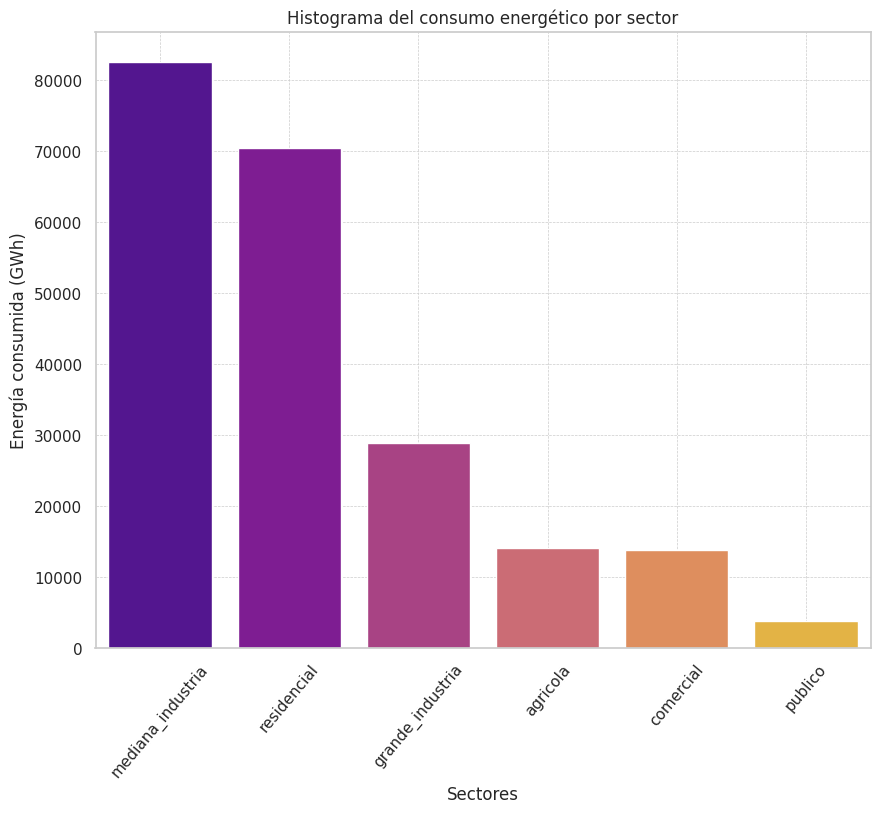

In [ ]:
def histograma (tabla, eje_x, eje_y, titulo, x_label, y_label):
  plt.figure(figsize=(10,8))
  sns.set(style = 'whitegrid')
  sns.barplot(x = eje_x, y= eje_y, palette=sns.color_palette("plasma", n_colors=len(tabla)))

  plt.title(titulo)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.xticks(rotation=50)
  plt.grid(axis='y')
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)
  plt.show()

df_sectores.sort_values(by='Total (GWh)', ascending=False, inplace=True)
titulo = 'Histograma del consumo energético por sector'
x_label = 'Sectores'
y_label = 'Energía consumida (GWh)'
histograma(df_sectores,df_sectores.index, df_sectores['Total (GWh)'], titulo, x_label, y_label)

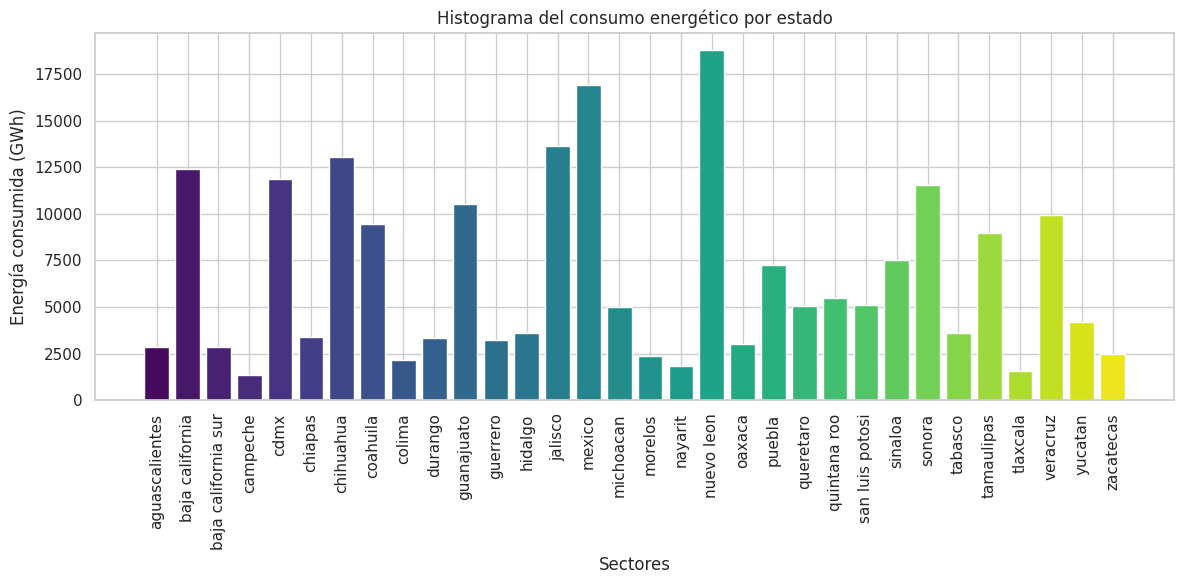

In [ ]:
consumo_por_estado = pd.DataFrame({
    'Estado':df_consumo_energetico_estado['estado'],
    'Consumo':df_consumo_energetico_estado['total']
  })

titulo = 'Histograma del consumo energético por estado'
x_label = 'Sectores'
y_label = 'Energía consumida (GWh)'

plt.figure(figsize=(12, 6))

color = sns.color_palette('viridis', len(consumo_por_estado))
plt.bar(consumo_por_estado['Estado'], consumo_por_estado['Consumo'], color = color)

plt.xticks(rotation=90)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(titulo)
plt.tight_layout()
plt.show()

In [ ]:
#Ejecutar una sola vez
consumo_plot = df_consumo_energetico_estado.set_index('estado')
consumo_plot.drop(columns='total', inplace=True)

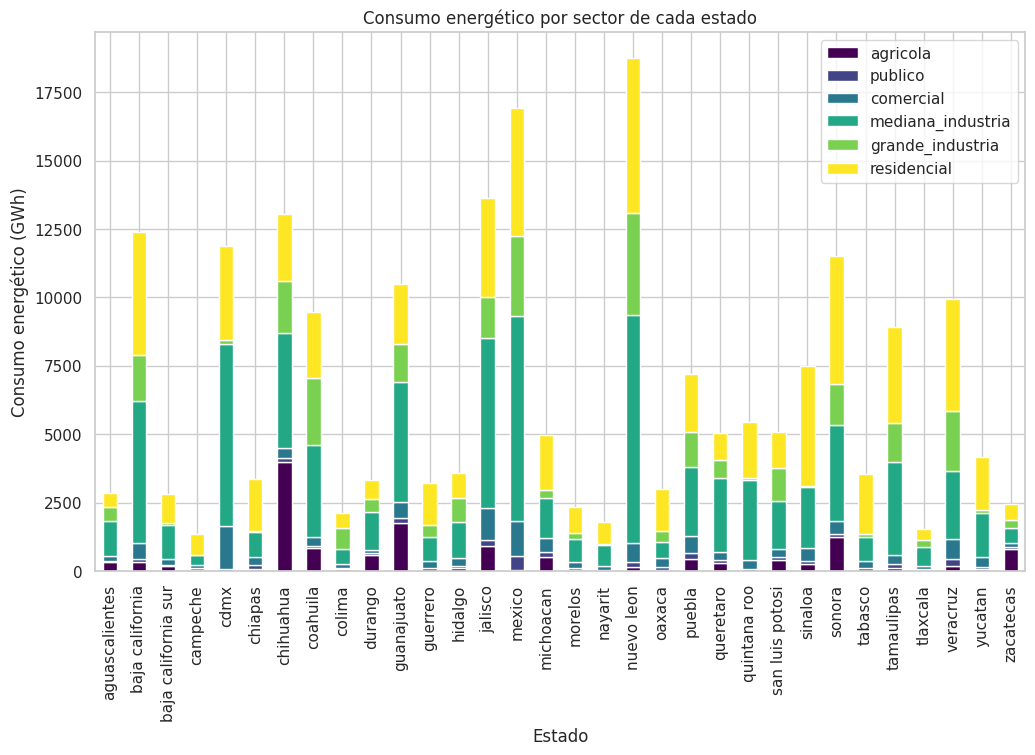

In [ ]:
ax = consumo_plot.plot(kind='bar', stacked=True, figsize = (12,7), colormap='viridis')

#Diseño de la gráfica
plt.title('Consumo energético por sector de cada estado')
plt.xlabel('Estado')
plt.ylabel('Consumo energético (GWh)')

plt.show()

estados = list(df_consumo_energetico_estado['estado'])

Mapa de calor de zonas de México con potencial energético

/tmp/ipython-input-1559864155.py:34: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



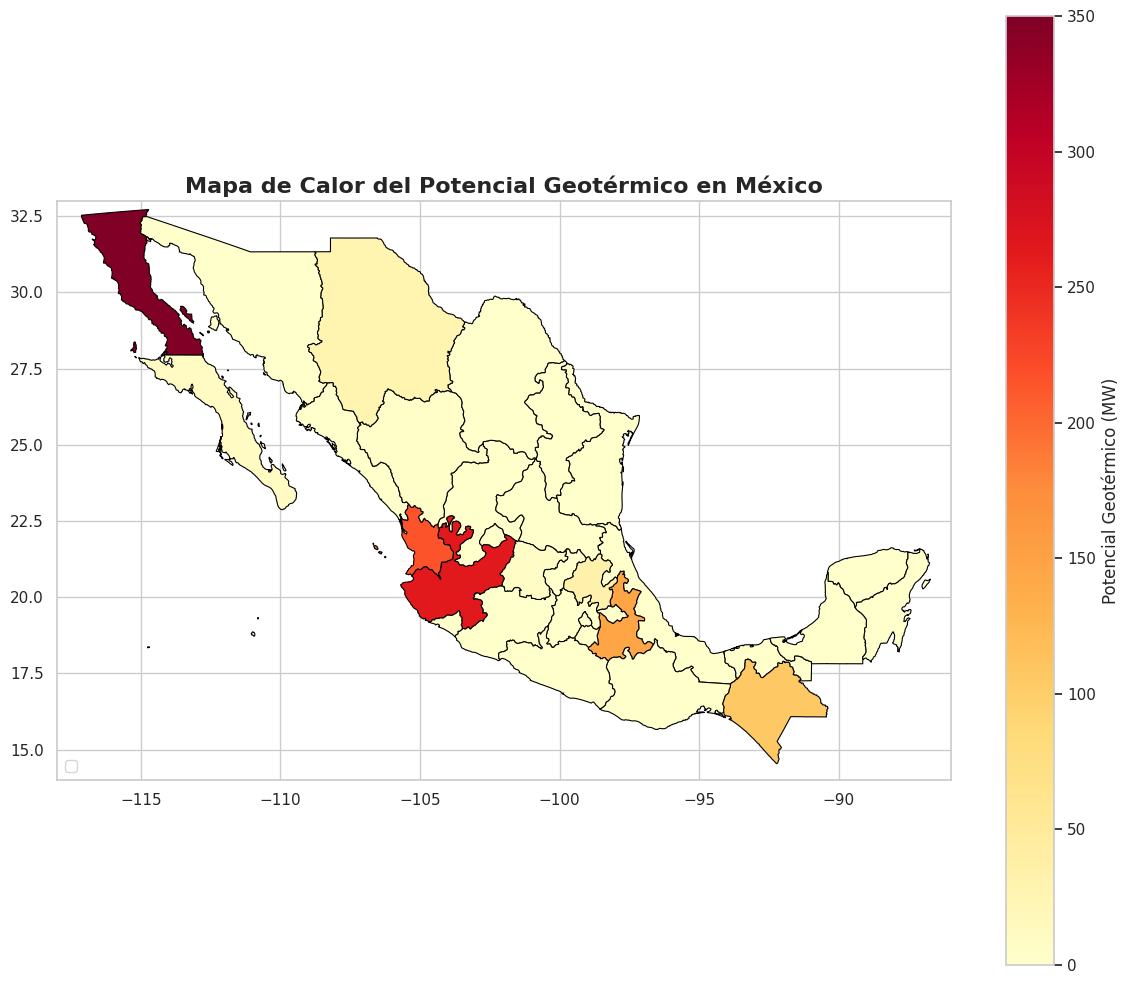

In [ ]:
df_potencial_geotermico.replace(720, 350, inplace=True)
df_mapacalor = df_potencial_geotermico.groupby('estado')['potencial'].sum()

url = "https://raw.githubusercontent.com/angelnmara/geojson/master/mexicoHigh.json"
mexico = gpd.read_file(url)

mapa = mexico.merge(df_mapacalor, how='left', left_on='name', right_on='estado')
mapa['potencial'] = mapa['potencial'].fillna(0)
fig, ax = plt.subplots(figsize=(12, 10))

mapa.plot(column='potencial',
          cmap='YlOrRd',
          linewidth=0.8,
          edgecolor='black',
          ax=ax,
          legend=True,
          missing_kwds={
              "color": "lightgrey",
              "edgecolor": "black",
              "hatch": "///",
              "label": "Sin datos"
          },
          legend_kwds={
              'label': "Potencial Geotérmico (MW)",
              'orientation': "vertical"
          })

ax.set_title('Mapa de Calor del Potencial Geotérmico en México',
             fontdict={'fontsize': 16, 'fontweight': 'bold'})

ax.set_xlim(-118, -86)
ax.set_ylim(14, 33)

plt.legend(loc='lower left')

plt.tight_layout()
plt.show()
df_potencial_geotermico.replace(350, 720, inplace=True)

Bihistograma

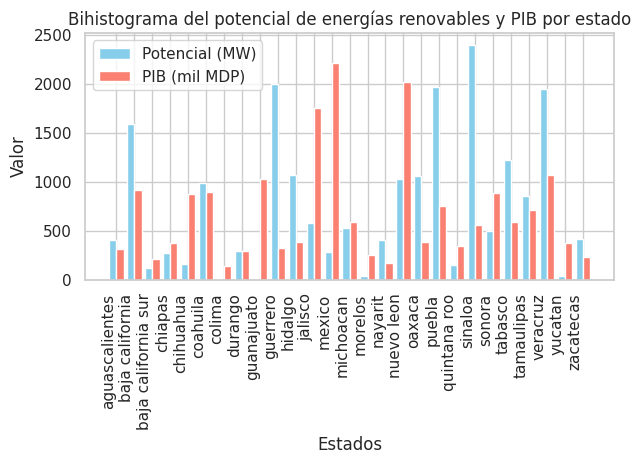

In [ ]:
capacidad_por_estado = df_energialimpia_por_estado.groupby('estado')['capacidad_instalada_(mw)'].sum()
capacidad_pib_por_estado = pd.merge(capacidad_por_estado, df_pib_por_estado, on='estado')
capacidad_pib_por_estado['2021'] = capacidad_pib_por_estado['2021'].apply(lambda x: x/1000) #El PIB se divide entre mil para que sea mas visual

x = np.arange(len(capacidad_pib_por_estado['estado']))
ancho = 0.4

plt.bar(x - ancho/2, capacidad_pib_por_estado['capacidad_instalada_(mw)'], width=ancho, label='Potencial (MW)', color='skyblue')
plt.bar(x + ancho/2, capacidad_pib_por_estado['2021'], width=ancho, label='PIB (mil MDP)', color='salmon')

plt.xticks(x, capacidad_pib_por_estado['estado'], rotation=90, ha='right')

plt.xlabel('Estados')
plt.ylabel('Valor')
plt.title('Bihistograma del potencial de energías renovables y PIB por estado')
plt.legend()

plt.tight_layout()  # Ajusta para que no se corten las etiquetas
plt.show()


Treemap

In [ ]:
capacidad_mexico = df_energialimpia_por_estado.groupby(['estado','tipo_de_energia_limpia'])['capacidad_instalada_(mw)'].sum()
capacidad_mexico = capacidad_mexico.drop(['biomasa','cogeneracion eficiente','total', 'nuclear','otro'], level='tipo_de_energia_limpia')
capacidad_mexico.head(5)

estado           tipo_de_energia_limpia
aguascalientes   eolica                    129.00
                 solar                       0.79
baja california  eolica                    166.60
                 geotermica                574.85
                 solar                     575.89
Name: capacidad_instalada_(mw), dtype: float64

In [ ]:
capacidad_mexico.drop('nacional', inplace=True)

fig = px.treemap(capacidad_mexico.reset_index(),
                 path = ['estado', 'tipo_de_energia_limpia'],
                 values = 'capacidad_instalada_(mw)',
                 color = 'capacidad_instalada_(mw)',
                 color_continuous_scale='Oranges',
                 title='Treemap de potencial de energías renovables por estado'
                )
fig.data[0].textinfo = 'label+value'
fig.show()

Regresión Lineal

--------------COEFICIENTE DE CORRELACIÓN DE PEARSON--------------------
El coeficiente entre la hora y la radiación solar es 0.07611269463984717
-----------------------REGRESIÓN LINEAL--------------------------------
La ecuación de la regresión lineal es 3.63x + 184.73


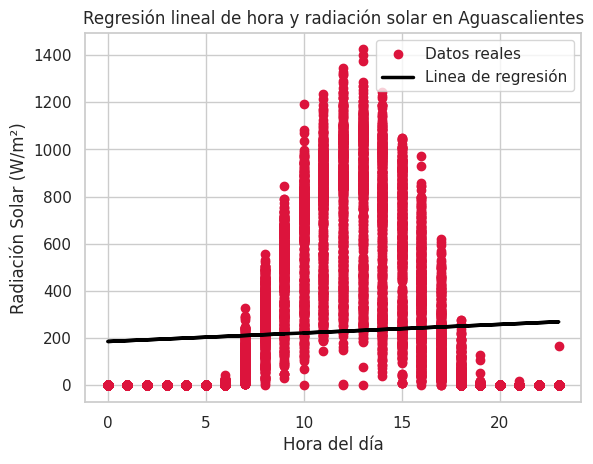

In [ ]:
df_ags['Radiación Solar (W/m²)'] = pd.to_numeric(df_ags['Radiación Solar (W/m²)'], errors='coerce')
df_regresion = df_ags.dropna(subset=['Fecha Local', 'Radiación Solar (W/m²)']).copy()

print("--------------COEFICIENTE DE CORRELACIÓN DE PEARSON--------------------")
coef, _ = pearsonr(df_regresion['Fecha Local'], df_regresion['Radiación Solar (W/m²)'])
print(f"El coeficiente entre la hora y la radiación solar es {coef}")

print("-----------------------REGRESIÓN LINEAL--------------------------------")
x = df_regresion[['Fecha Local']]
y = df_regresion['Radiación Solar (W/m²)']
model = LinearRegression()
model.fit(x,y)

coeficiente = model.coef_[0]
intercepto = model.intercept_
print(f"La ecuación de la regresión lineal es {coeficiente:.2f}x + {intercepto:.2f}")

plt.scatter(x,y, color='crimson', label="Datos reales")
plt.title("Regresión lineal de hora y radiación solar en Aguascalientes")
plt.xlabel("Hora del día")
plt.ylabel("Radiación Solar (W/m²)")

plt.plot(x, model.predict(x), color='black', linewidth=2.5, label = "Linea de regresión")
plt.legend()
plt.grid(True)
plt.show()

Error estándar

In [ ]:
rad_solar = df_ags['Radiación Solar (W/m²)']
media_rad_solar = np.mean(df_ags['Radiación Solar (W/m²)'])
print(f"La media de la cantidad de radiación solar por hora es {round(media_rad_solar, 2)}")

desv_rad_solar = np.std(df_ags['Radiación Solar (W/m²)'], ddof = 1)
print(f"La desviación estándar de la cantidad de radiación solar por hora es {round(desv_rad_solar, 2)}")

n = len(df_ags['Radiación Solar (W/m²)'])
print(f"Tamaño de la muestra: {n}")

error_estandar = desv_rad_solar/np.sqrt(n)
print(f"El error estándar es de {round(error_estandar, 2)}")

La media de la cantidad de radiación solar por hora es 226.3
La desviación estándar de la cantidad de radiación solar por hora es 332.89
Tamaño de la muestra: 11922
El error estándar es de 3.05


Bootstrap e intervalo de confianza

In [ ]:
numero_remuestreos = 1000
medias_bootstrap = list()

for _ in range(numero_remuestreos):
  muestra = rad_solar.sample(n=len(rad_solar), replace=True)
  medias_bootstrap.append(muestra.mean())

medias_bootstrap = np.array(medias_bootstrap)
intervalo_confianza = np.percentile(medias_bootstrap, [2.5, 97.5])

print(f"Media estimada (Bootstrap): {np.mean(medias_bootstrap):.2f}")
print(f"Intervalo de confianza al 95%: {intervalo_confianza[0]:.2f} a {intervalo_confianza[1]:.2f}")

Media estimada (Bootstrap): 226.24
Intervalo de confianza al 95%: 220.22 a 232.20


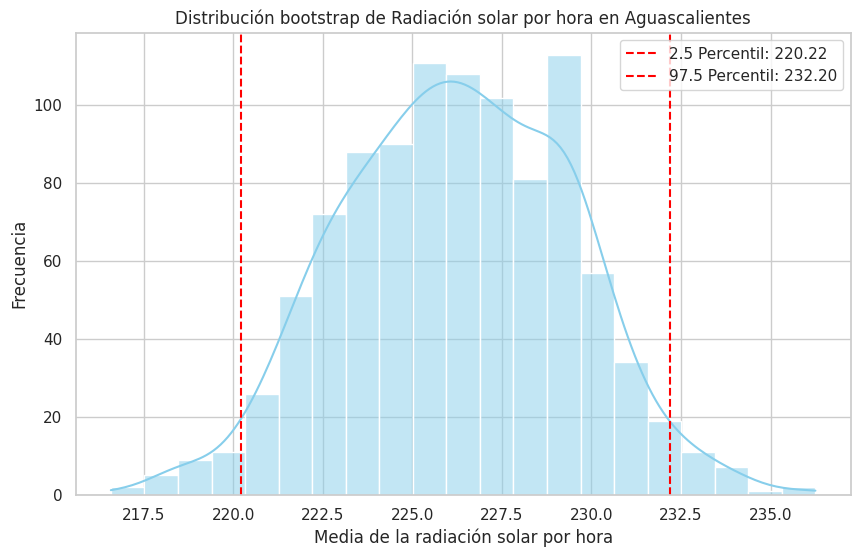

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(medias_bootstrap, kde=True, color='skyblue')

plt.axvline(intervalo_confianza[0], color='red', linestyle='--', label=f'2.5 Percentil: {intervalo_confianza[0]:.2f}')
plt.axvline(intervalo_confianza[1], color='red', linestyle='--', label=f'97.5 Percentil: {intervalo_confianza[1]:.2f}')

plt.title('Distribución bootstrap de Radiación solar por hora en Aguascalientes')
plt.xlabel('Media de la radiación solar por hora')
plt.ylabel('Frecuencia')
plt.legend()

plt.show()

Matriz de correlación

In [ ]:
#Correr una sola vez antes de correr el siguiente código
df_oaxaca = df_oaxaca.drop(columns=['Fecha Local', 'Fecha UTC', 'Precipitación (mm)', 'Humedad relativa (%)', 'Dirección del Viento (grados)','Dirección de ráfaga (grados)'])

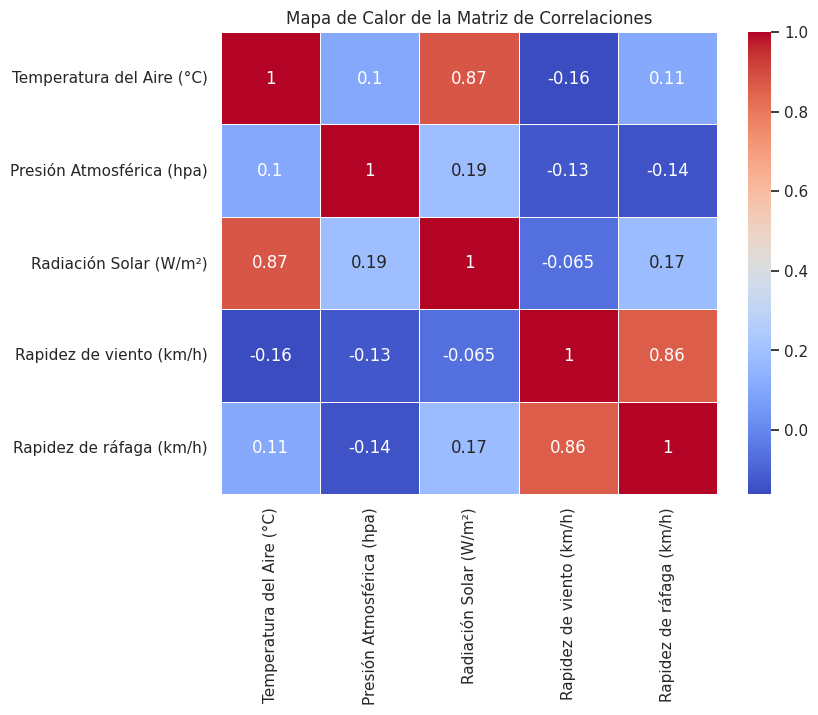

In [ ]:
correlation_matrix = df_oaxaca.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Personalizar el gráfico
plt.title('Mapa de Calor de la Matriz de Correlaciones')
plt.show()

Regresión logística

In [ ]:
df_oaxaca['Rapidez de viento (km/h)'] = pd.to_numeric(df_oaxaca['Rapidez de viento (km/h)'])
df_oaxaca['Radiación Solar (W/m²)'] = pd.to_numeric(df_oaxaca['Radiación Solar (W/m²)'])
df_oaxaca['Temperatura del Aire (°C)'] = pd.to_numeric(df_oaxaca['Temperatura del Aire (°C)'])
df_oaxaca['Presión Atmosférica (hpa)'] = pd.to_numeric(df_oaxaca['Presión Atmosférica (hpa)'])
df_oaxaca['Rapidez de ráfaga (km/h)'] = pd.to_numeric(df_oaxaca['Rapidez de ráfaga (km/h)'])

df_oaxaca['Rapidez de viento (km/h)'] = df_oaxaca['Rapidez de viento (km/h)'].apply(
    lambda x: 1 if x >= 10 else 0                                    #10km/h es la velocidad mínima para generar energía eolica
)

df_oaxaca = df_oaxaca.dropna(subset=['Temperatura del Aire (°C)', 'Presión Atmosférica (hpa)', 'Radiación Solar (W/m²)', 'Rapidez de viento (km/h)', 'Rapidez de ráfaga (km/h)'])

X = df_oaxaca[['Temperatura del Aire (°C)', 'Presión Atmosférica (hpa)', 'Radiación Solar (W/m²)']]
y = df_oaxaca['Rapidez de viento (km/h)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

score = logreg.score(X_test, y_test)
print(f"Precisión del modelo: {score:.2f}")

Precisión del modelo: 0.63


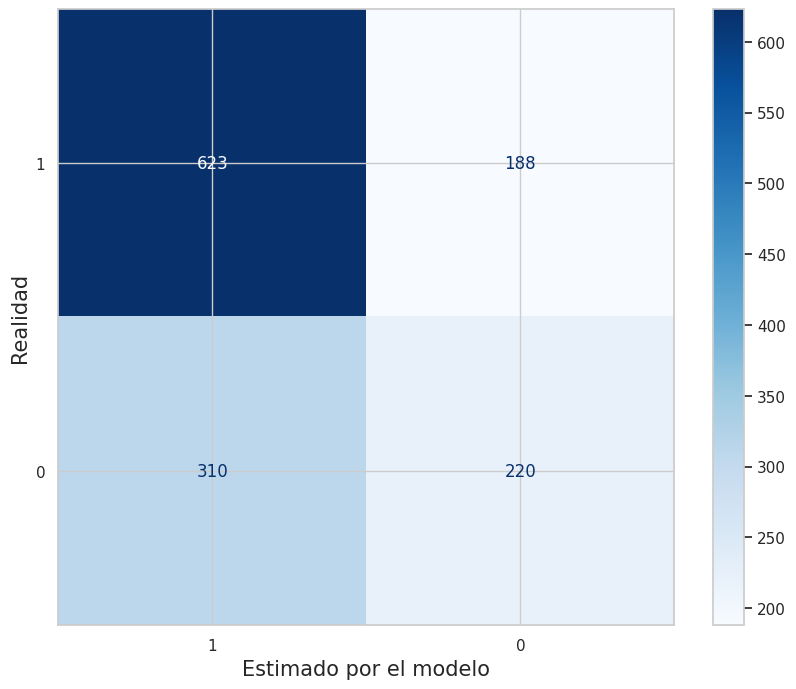

In [ ]:
y_pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

unique_labels = y_test.unique()

# Visualizar la matriz de confusión con tamaño ajustado
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
fig, ax = plt.subplots(figsize=(10, 8))  # Ajustar el tamaño de la figura aquí
disp.plot(cmap='Blues', ax=ax)  # Pasar el objeto ax al método plot
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15)
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, target_names=unique_labels, output_dict=True)

# Convertir el informe a un DataFrame
report_df = pd.DataFrame(report).transpose()
report_df.head()

,precision,recall,f1-score,support
1,0.667738,0.768187,0.714450,811.000000
0,0.539216,0.415094,0.469083,530.000000
accuracy,0.628635,0.628635,0.628635,0.628635
macro avg,0.603477,0.591641,0.591766,1341.000000
weighted avg,0.616943,0.628635,0.617474,1341.000000
